<a href="https://colab.research.google.com/github/mjmousavi97/Deep-Learning-Tehran-uni/blob/main/HomeWorks/05%20HW/src/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
import zipfile
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
import tensorflow as tf
import numpy as np

from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam

In [2]:
uploaded = files.upload()

Saving Annotations.zip to Annotations (2).zip
Saving Images.zip to Images (2).zip


In [3]:
with zipfile.ZipFile('/content/Images.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [4]:
with zipfile.ZipFile('/content/Annotations.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [5]:
file_name = 'airplane_440'
img = cv2.imread(os.path.join('/content/Images/Images/', file_name + '.jpg'))

In [6]:
df = pd.read_csv(os.path.join('/content/Airplanes_Annotations/',  file_name + '.csv'))

In [7]:
df

,1
0,115 53 219 156


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

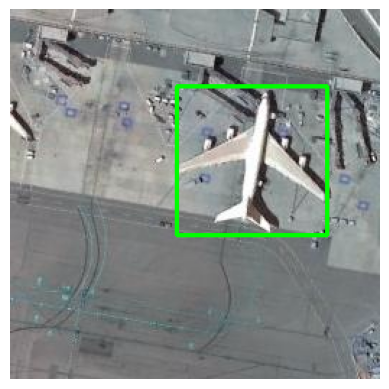

In [8]:
for i, row in df.iterrows():
    _, row = next(row.items())

    x1 = int(row.split(' ')[0])
    y1 = int(row.split(' ')[1])
    x2 = int(row.split(' ')[2])
    y2 = int(row.split(' ')[3])

    cv2.rectangle(img=img, pt1=(x1, y1), pt2=(x2, y2), color=(0, 255, 0), thickness=2)

plt.figure()
plt.imshow(img)
plt.axis('off')


# **Intersection of Union**

In [9]:
def iou_calc(box1: dict, box2: dict) -> float:
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Each box should be a dictionary with keys:
        'x1', 'y1' -> coordinates of the top-left corner
        'x2', 'y2' -> coordinates of the bottom-right corner

    Returns a float between 0.0 and 1.0 representing how much the boxes overlap.
    If they don't overlap at all, returns 0.0.

    Example:
        box_a = {'x1': 0, 'y1': 0, 'x2': 2, 'y2': 2}
        box_b = {'x1': 1, 'y1': 1, 'x2': 3, 'y2': 3}
        iou_calc(box_a, box_b)  # returns 0.142857...
    """
    x1 = max(box1['x1'], box2['x1'])
    y1 = max(box1['y1'], box2['y1'])
    x2 = min(box1['x2'], box2['x2'])
    y2 = min(box1['y2'], box2['y2'])

    if x2 < x1 or y2 < y1:
        return 0.0

    intersection_area = (x2 - x1) * (y2 - y1)

    box1_area = (box1['x2'] - box1['x1']) * (box1['y2'] - box1['y1'])
    box2_area = (box2['x2'] - box2['x1']) * (box2['y2'] - box2['y1'])

    iou = intersection_area / float(box1_area + box2_area - intersection_area)

    return iou


In [10]:
box_a = {'x1': 0, 'y1': 0, 'x2': 2, 'y2': 2}
box_b = {'x1': 1, 'y1': 1, 'x2': 3, 'y2': 3}

iou_calc(box_a, box_b)

0.14285714285714285

# **Selective Search**
It is based on computing hierarchical grouping of similar regions based on color, texture, size and shape compatibility.

In [13]:
!pip uninstall opencv-python opencv-contrib-python -y


Found existing installation: opencv-python 4.12.0.88
Uninstalling opencv-python-4.12.0.88:
  Successfully uninstalled opencv-python-4.12.0.88
Found existing installation: opencv-contrib-python 4.12.0.88
Uninstalling opencv-contrib-python-4.12.0.88:
  Successfully uninstalled opencv-contrib-python-4.12.0.88


In [14]:
!pip install opencv-contrib-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 MB 10.8 MB/s eta 0:00:00


Number of selected proposals: 572


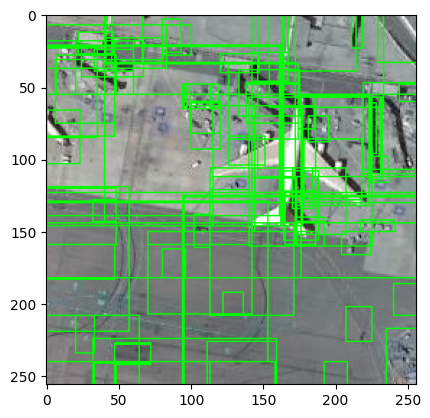

In [11]:
file_name = 'airplane_440'
img = cv2.imread(os.path.join('/content/Images/Images/', file_name + '.jpg'))
image_copy = img.copy()  # make a copy to draw on

# create selective search object and set image
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image_copy)
ss.switchToSelectiveSearchFast()  # quick mode (less accurate but faster)

rects = ss.process()  # list of region proposals (x, y, w, h)
print(f'Number of selected proposals: {rects.shape[0]}')

# draw the 100 proposals on image
for idx, rect in enumerate(rects[:100, :]):
    x1, y1, w, h = rect
    x2, y2 = x1 + w, y1 + h
    cv2.rectangle(image_copy, (x1, y1), (x2, y2), (0, 255, 0), 1)

plt.imshow(image_copy)  # show image with drawn box


### Data Generation Process

For each batch, the generator performs the following steps:

1. **Load Images & Annotations**: Reads each image and its corresponding CSV file containing ground-truth bounding boxes.  
2. **Generate Proposals**: Uses Selective Search to propose candidate regions in the image.  
3. **Compute IoU**: For each proposal, calculates the Intersection over Union (IoU) with all ground-truth boxes.  
4. **Assign Labels**:  
   - Positive (plane) if IoU > 0.7, up to a maximum of 80 per image.  
   - Negative (background) if IoU < 0.3, up to a maximum of 80 per image.  
5. **Crop & Resize**: Crops the proposal from the image and resizes it to the target dimensions.  
6. **Return Batch**: Outputs the batch as arrays of images (`X`) and one-hot encoded labels (`y`).  

This ensures a balanced set of positive and negative samples while limiting each image to 100 proposals.


In [12]:
class DataGenerator(keras.utils.Sequence):
    """
    Data generator for object detection using Selective Search with balanced labels.

    This generator loads images and their annotations, applies Selective Search
    to generate region proposals, and assigns labels based on IoU overlap with
    ground-truth bounding boxes. It ensures a maximum number of positive and
    negative proposals per image to maintain class balance.

    Each image contributes a fixed number of region proposals (up to 100),
    with at most 80 positives and 80 negatives per image.

    Parameters
    ----------
    list_names : list of str
        List of image filenames to be used by the generator.
    batch_size : int, optional, default=32
        Number of images per batch (each produces 100 region proposals).
    dim : tuple of int, optional, default=(224, 224)
        Target size (height, width) for resizing cropped proposals.
    n_channels : int, optional, default=3
        Number of image channels (e.g., 3 for RGB).
    n_classes : int, optional, default=2
        Number of output classes (e.g., plane vs background).
    shuffle : bool, optional, default=False
        Whether to shuffle the dataset between epochs.
    img_path : str, optional, default='./'
        Path to the folder containing images.
    annot_path : str, optional, default='./'
        Path to the folder containing CSV annotation files.
    """

    def __init__(self, list_names, batch_size=32, dim=(224, 224), n_channels=3,
                 n_classes=2, shuffle=False, img_path='./', annot_path='./'):
        super().__init__(**kwargs)

        self.list_names = list_names
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.img_path = img_path
        self.annot_path = annot_path

    def __len__(self):
        """Returns the number of batches per epoch."""
        return int(np.floor(len(self.list_names) / self.batch_size))

    def __getitem__(self, index):
        """Generates one batch of data."""
        indexes = self.list_names[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        return X, y

    def __data_generation(self, indexes):
        """Generates data containing batch_size * 100 proposals with balanced labels."""
        ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
        X = np.zeros((self.batch_size * 100, *self.dim, self.n_channels), dtype=np.float32)
        Y = np.zeros((self.batch_size * 100), dtype=int)

        for batch_idx, fname in enumerate(indexes):
            base_idx = batch_idx * 100
            image = cv2.imread(os.path.join(self.img_path, fname))
            if image is None:
                continue

            # Load ground truth bounding boxes
            ann_file = os.path.join(self.annot_path, fname.split(".")[0] + ".csv")
            df = pd.read_csv(ann_file)
            gtvalues = []
            for _, row_series in df.iterrows():
                for _, row in row_series.items():
                    coords = row.split(' ')
                    if len(coords) < 4:
                        continue
                    x1, y1, x2, y2 = map(int, coords[:4])
                    gtvalues.append({'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2})

            # Generate region proposals using Selective Search
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            rects = ss.process()
            plane_cnt, background_cnt = 0, 0

            # Keep up to 100 proposals per image
            for rect in rects:
                if plane_cnt + background_cnt >= 100:
                    break

                x, y, w, h = rect
                x2, y2 = x + w, y + h

                # Skip invalid or out-of-bounds boxes
                if x2 <= x or y2 <= y or x < 0 or y < 0 or x2 > image.shape[1] or y2 > image.shape[0]:
                    continue

                # Compute IoU with ground truth boxes
                box2 = {'x1': x, 'y1': y, 'x2': x2, 'y2': y2}
                ious = [iou_calc(box2, gt) for gt in gtvalues]
                iou = max(ious) if ious else 0

                current_index = base_idx + plane_cnt + background_cnt

                # Assign positive label if IoU > 0.7 and max 80 positives not reached
                if iou > 0.7 and plane_cnt < 80:
                    crop = image[y:y2, x:x2]
                    resized = cv2.resize(crop, self.dim, interpolation=cv2.INTER_AREA)
                    X[current_index] = resized
                    Y[current_index] = 1
                    plane_cnt += 1

                # Assign negative label if IoU < 0.3 and max 80 negatives not reached
                elif iou < 0.3 and background_cnt < 80:
                    crop = image[y:y2, x:x2]
                    resized = cv2.resize(crop, self.dim, interpolation=cv2.INTER_AREA)
                    X[current_index] = resized
                    Y[current_index] = 0
                    background_cnt += 1

        return X, keras.utils.to_categorical(Y, num_classes=self.n_classes)


In [13]:
# get names of image
list_names = os.listdir('/content/Images/Images')
# create train generator and validation generator
training_generator = DataGenerator(list_names = list_names[:100], batch_size = 1, img_path= '/content/Images/Images', annot_path = '/content/Airplanes_Annotations')
validation_generator = DataGenerator(list_names = list_names[100:120], batch_size = 1, img_path= '/content/Images/Images', annot_path = '/content/Airplanes_Annotations')

In [14]:
X, Y = validation_generator.__getitem__(14)

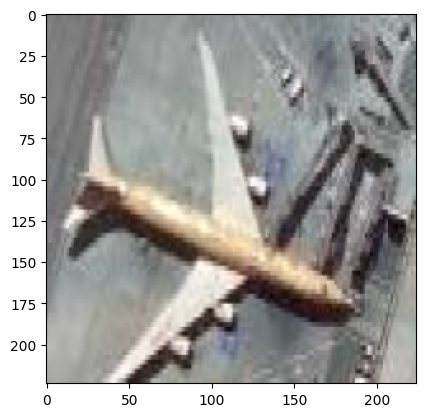

In [15]:
plt.imshow(X[80].astype(int))

In [16]:
Y[80]

array([0., 1.])

# **Model- Fine tuning**

In [17]:
vgg_model = VGG16(weights='imagenet')
vgg_model.summary()


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
X = vgg_model.layers[-2].output
prediction = Dense(2, activation='softmax')(X)
model = Model(inputs=vgg_model.input, outputs=prediction)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         8,194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 134,268,738 (512.19 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(x=training_generator, batch_size=30, validation_data=validation_generator, epochs=10)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8546 - loss: 0.6594

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
